# Elastic wave equation implementation on a staggered grid + Free surface B.C + vertical force

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Vertical force

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

And the vertical force is injected into the update for velocities as shown in the equation below.

**N.B. The force cannot be injected at the first grid point of the model as we are not currently computing 
particle velocities explicitly at the free surface.**

From Fitchner, pages 48 and 49:

*Robertsson (1996) proposed a very pragmatic variant of the image method. Instead of explicitly computing the velocity components above the surface, they are collectively set to zero. Only the discrete stresses are imaged as in Eqs. (3.80b), (3.80c) and (3.80d).*

**TO DO: Simulate particle velocities using 3.82 to 3.90 of Fitchner** 


# Vectorial form

While conventional litterature writes the elastic wave-equation as a set of scalar PDEs, the higher level representation comes from Hooke's law and the equation of motion and writes as:

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau + f \\
&\frac{d \tau}{dt} = \lambda tr(\nabla v) \mathbf{I}  + \mu (\nabla v + (\nabla v)^T)
\end{cases}

and as $tr(\nabla v)$ is the divergence of $v$ we can reqrite it as

\begin{cases}
&\frac{dv}{dt} = \nabla . \tau + f\\
&\frac{d \tau}{dt} = \lambda \text{diag}(\nabla . v) + \mu (\nabla v + (\nabla v)^T)
\end{cases}

where $v$ is a vector valued function:

$v(t, x, y) = (v_x(t, x, y), v_y(t, x, y)$

and the stress $\tau$ is a symmetric tensor valued function:


$\tau(t, x, y) = \begin{bmatrix}\tau_{xx}(t, x, y) & \tau_{xy}(t, x, y)\\\tau_{xy}t, x, y) & \tau_{yy}(t, x, y)\end{bmatrix}$


We show in the following how to setup the elastic wave-equation form Devito's high-level tensorial types.



In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource, TimeAxis, Receiver
from examples.seismic import plot_image, Model
import numpy as np
import matplotlib.pyplot as plt

from sympy import init_printing, latex
init_printing(use_latex='mathjax')

In [2]:
origin=(0., 0.)
shape=(100, 100)
spacing=(10, 10)
vp = 3.0*np.ones(shape)
vs = 1.5*np.ones(shape)
b = np.ones(shape)*0.0005   ### CAUTION: 1/density

so=4 ### Space order of discretization

model = Model(origin=origin, shape=shape, spacing=spacing, 
              space_order=so, bcs='mask', fs=True, vp=vp, vs=vs, b=b, nbl=100)
grid = model.grid

Operator `initdamp` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s
Operator `padfunc` run in 0.01 s


In [3]:
model.grid.subdomains

{'domain': SubDomain domain[(x, y)],
 'interior': SubDomain interior[(i0x, i0y)],
 'physdomain': SubDomain physdomain[(x, i1y)],
 'fsdomain': SubDomain fsdomain[(x, i2y)]}

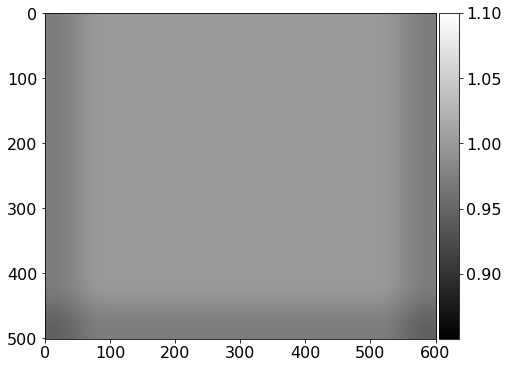

Shape of entire domain: (601, 501)
Shape of free-surface domain: (601, 4)
Shape of interior: (599, 499)
Shape of physical domain: (601, 497)


In [4]:
### Plot the damping term. Observe how only the side boundaries have the damping layer
plot_image(model.damp.data)
print("Shape of entire domain:",model.grid.subdomains['domain'].shape)
print("Shape of free-surface domain:",model.grid.subdomains['fsdomain'].shape)
print("Shape of interior:",model.grid.subdomains['interior'].shape)
print("Shape of physical domain:",model.grid.subdomains['physdomain'].shape)

# CFL condition (stability) and numerical dispersion condition 

In [5]:
### CFL condition: Devito automatically calculates the time-stepping required to ensure stability 
### Refer to eqn 10 of FDELMODC manual for example
h = np.max(spacing)
dt_eq10 = (h*0.606) / 2.  ###For fourth order scheme, Courant number is 0.606, dx=3.75 and vmax=2.0
dt_devito = model.critical_dt
print("Time stepping that satisfies CFL is", dt_eq10, "ms")

Time stepping that satisfies CFL is 1.13625 ms


In [6]:
np.isclose(dt_eq10, dt_devito, rtol=1e-02, atol=1e-02)

True

In [7]:
### We need a minimum of 5 points per wavelength for dispersion free propagation
### Refer to equation 11 of the FDELMODC manual

fmax = 1.0/(5*h)
print("Maximum frequency that can be propagated without numerical dispesion is", fmax, "kHz")

Maximum frequency that can be propagated without numerical dispesion is 0.05333333333333334 kHz


In [8]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=2000. and dx=7.5
t0, tn = 0., 1000.
dt = 0.5*model.critical_dt   
time_range = TimeAxis(start=t0, stop=tn, step=dt)

src = RickerSource(name='src', grid=grid, f0=0.01, time_range=time_range)
src.coordinates.data[:] = [750., 2.0*h] # Source is injected two grid points below

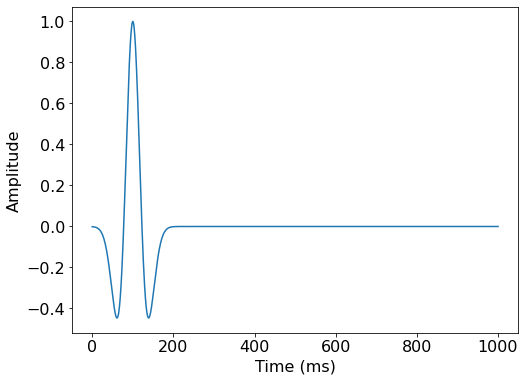

In [9]:
#NBVAL_SKIP

src.show()

Text(0, 0.5, 'Amplitude')

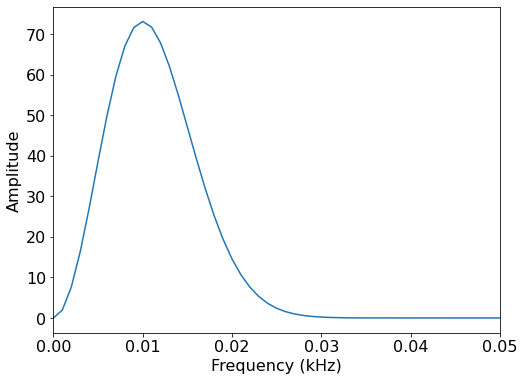

In [10]:
freqs = np.fft.rfftfreq(src.data.shape[0], d=dt)
spec = np.fft.rfft(src.data.flatten())
plt.plot(freqs,np.abs(spec))
plt.xlim([0, 0.05])
plt.xlabel("Frequency (kHz)")
plt.ylabel("Amplitude")

In [11]:
# Now we create the velocity and pressure fields
v = VectorTimeFunction(name='v', grid=grid, space_order=so, time_order=1)
tau = TensorTimeFunction(name='t', grid=grid, space_order=so, time_order=1)

In [12]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim


# The source injection term
f_z = src.inject(field=v.forward[1], expr=dt*src)

# Define receivers to record horizontal and vertical components of particle velocity
#Note: the moon data may be accelerations, but one integrates recorded data in time to obtain velocities


nrec = 101
rech = Receiver(name="rech", grid=model.grid, npoint=nrec, time_range=time_range)
rech.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
rech.coordinates.data[:, -1] = 0.
recv = Receiver(name="recv", grid=model.grid, npoint=nrec, time_range=time_range)
recv.coordinates.data[:, 0] = np.linspace(0., model.domain_size[0], num=nrec)
recv.coordinates.data[:, -1] = 0.

rec_horiz = rech.interpolate(expr=v[0])
rec_vert = recv.interpolate(expr=v[1])

# Thorbecke's parameter notation

mu = model.mu
l = model.lam
ro = model.b

# fdelmodc reference implementation
u_v = Eq(v.forward, (model.damp) *(v + dt*ro*div(tau)), subdomain=model.grid.subdomains['domain'])
u_t = Eq(tau.forward, tau + (model.damp) *(dt * l * diag(div(v.forward)) 
        + dt * mu * (grad(v.forward) + grad(v.forward).T)), 
         subdomain=model.grid.subdomains['physdomain'])



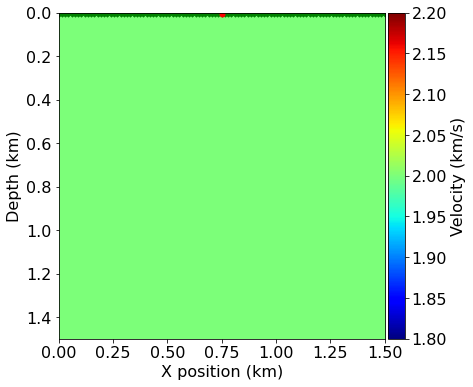

In [13]:
from examples.seismic import plot_velocity
plot_velocity(model, source=src.coordinates.data, receiver=recv.coordinates.data,  colorbar=True)

In [14]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y), v_y(t + dt, x, y + h_y/2)), Vector((0.568000018596649*(Derivative(t_xx(t, x, y), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2), y))*b(x, y) + v_x(t, x + h_x/2, y))*damp(x, y), (0.568000018596649*(Derivative(t_xy(t, x + h_x/2, y + h_y/2), x) + Derivative(t_yy(t, x, y), y))*b(x, y) + v_y(t, x, y + h_y/2))*damp(x, y)))

In [15]:
u_t

Eq(SymmetricTensor( t_xx(t + dt, x, y), t_xy(t + dt, x + h_x/2, y + h_y/2), t_yy(t + dt, x, y),), Tensor( (0.568000018596649*(Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 1.1360000371933*mu(x, y)*Derivative(v_x(t + dt, x + h_x/2, y), x))*damp(x, y) + t_xx(t, x, y), 0.568000018596649*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*damp(x, y)*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2), 0.568000018596649*(Derivative(v_x(t + dt, x + h_x/2, y), y) + Derivative(v_y(t + dt, x, y + h_y/2), x))*damp(x, y)*mu(x, y) + t_xy(t, x + h_x/2, y + h_y/2), (0.568000018596649*(Derivative(v_x(t + dt, x + h_x/2, y), x) + Derivative(v_y(t + dt, x, y + h_y/2), y))*lam(x, y) + 1.1360000371933*mu(x, y)*Derivative(v_y(t + dt, x, y + h_y/2), y))*damp(x, y) + t_yy(t, x, y),))

## Free surface boundary condition
## Refer to pages 21-22 of FDELMODC or eqns 3.80a--d of Fichtner

In [16]:
def freesurface_top(model, tau_func, v_func):
    time = tau_func.grid.stepping_dim
    pos = int(max(tau_func.space_order, v_func.space_order)/2)
    #pos = int((tau_func.space_order)/2)
    x = tau_func.grid.dimensions[0]
    
    tau_yy_0 = [Eq(tau[1,1][time+1, x, pos], 0., subdomain=model.grid.subdomains['fsdomain'])] 
    tau_yy_mirror = [Eq(tau[1,1][time+1, x, i], -tau[1,1][time+1, x, 2*pos-i], 
                   subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    tau_xy_mirror = [Eq(tau[0,1][time+1, x, i], -tau[0,1][time+1, x, 2*pos-i], 
                 subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    tau_yx_mirror = [Eq(tau[1,0][time+1, x, i], -tau[1,0][time+1, x, 2*pos-i], 
                 subdomain=model.grid.subdomains['fsdomain']) for i in range(pos)]
    tau_xx = [Eq(tau[0,0].forward, l*grad(v.forward)[0,0]
                 + 2.0*mu * (grad(v.forward)[0,0]), 
                 subdomain=model.grid.subdomains['fsdomain'])]
    
    return tau_yy_0 + tau_yy_mirror + tau_xy_mirror + tau_yx_mirror + tau_xx

bc = freesurface_top(model, tau, v)

In [17]:
bc ##Not sure why these equations get printed differently, but this will do for now! 

⎡                                                                             
⎢t_yy[t + 1, x, 2] = 0.0, t_yy[t + 1, x, 0] = -t_yy[t + 1, x, 4], t_yy[t + 1, 
⎣                                                                             

                                                                              
x, 1] = -t_yy[t + 1, x, 3], t_xy[t + 1, x, 0] = -t_xy[t + 1, x, 4], t_xy[t + 1
                                                                              

                                                                              
, x, 1] = -t_xy[t + 1, x, 3], t_xy[t + 1, x, 0] = -t_xy[t + 1, x, 4], t_xy[t +
                                                                              

                                                              ∂ ⎛  ⎛          
 1, x, 1] = -t_xy[t + 1, x, 3], tₓₓ(t + dt, x, y) = lam(x, y)⋅──⎜vₓ⎜t + dt, x 
                                                              ∂x⎝  ⎝          

  hₓ   ⎞⎞               ∂ ⎛  ⎛            hₓ   ⎞

In [18]:
u_v

Eq(Vector(v_x(t + dt, x + h_x/2, y), v_y(t + dt, x, y + h_y/2)), Vector((0.568000018596649*(Derivative(t_xx(t, x, y), x) + Derivative(t_xy(t, x + h_x/2, y + h_y/2), y))*b(x, y) + v_x(t, x + h_x/2, y))*damp(x, y), (0.568000018596649*(Derivative(t_xy(t, x + h_x/2, y + h_y/2), x) + Derivative(t_yy(t, x, y), y))*b(x, y) + v_y(t, x, y + h_y/2))*damp(x, y)))

In [19]:
op = Operator([u_v] + [u_t] + bc + f_z + rec_horiz + rec_vert)

In [20]:
#NBVAL_IGNORE_OUTPUT

op()

Operator `Kernel` run in 15.59 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=15.545465, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.0009060000000000151, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section2', rank=None),
  PerfEntry(time=0.01981100000000021, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section3', rank=None),
  PerfEntry(time=0.015517000000000272, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

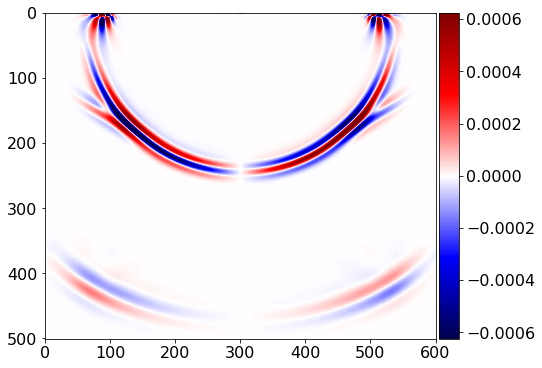

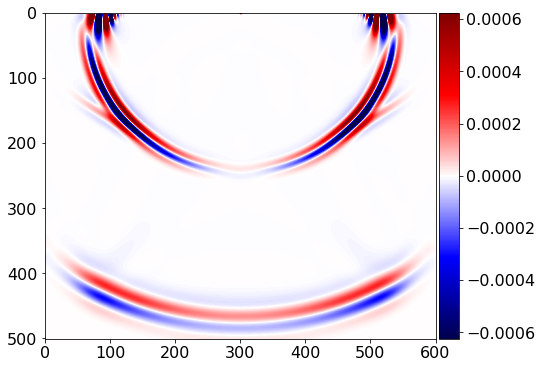

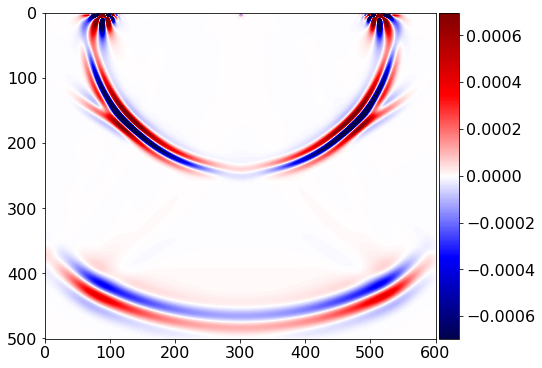

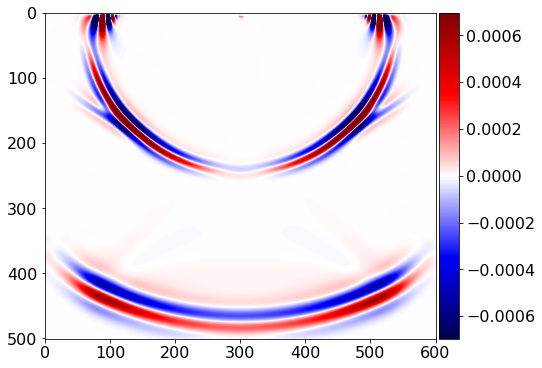

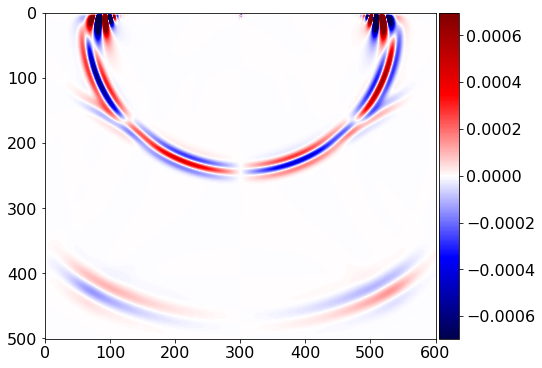

In [21]:
#NBVAL_SKIP
scale_v = max(np.percentile(np.abs(v[0].data), 99), np.percentile(np.abs(v[1].data),99))
scale_tau = max(np.percentile(np.abs(tau[0,0].data),99), np.percentile(np.abs(tau[0,1].data),99), 
                   np.percentile(np.abs(tau[1,0].data),99), np.percentile(np.abs(tau[1,1].data),99))
# Let's see what we got....
plot_image(v[0].data[0], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(v[1].data[0], vmin=-scale_v, vmax=scale_v, cmap="seismic")
plot_image(tau[0, 0].data[0], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")
plot_image(tau[1,1].data[0], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")
plot_image(tau[0,1].data[0], vmin=-scale_tau, vmax=scale_tau, cmap="seismic")

In [22]:
from examples.seismic import plot_shotrecord

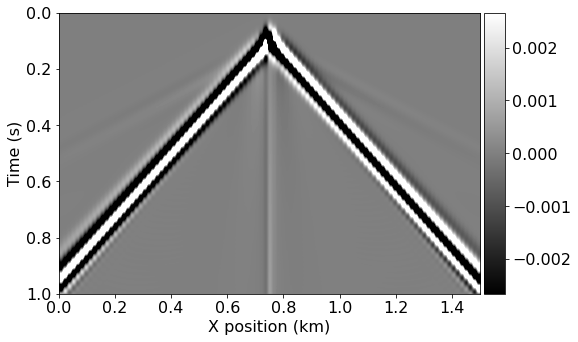

In [23]:
## Horizontal component of particle velocities recorded at the surface
plot_shotrecord(rech.data, model, t0, tn, colorbar=True)

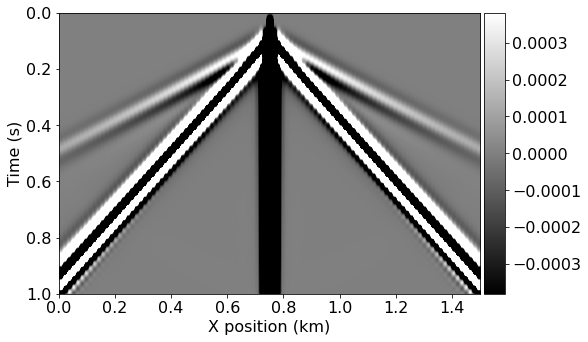

In [24]:
## Vertical component of particle velocities recorded at the surface
plot_shotrecord(recv.data, model, t0, tn, colorbar=True)

# **TODO: compare with fdelmod for accuracy!**